In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Utils
import src.utils.visualization.gantt_diagram as gantt
from src.utils.rolling_process.rolling_filter import *
from src.utils.editor import enrich_schedule_dframe
from src.utils.initialization import jobs_jssp_init as init

from src.utils.initialization.gen_deadlines import get_temporary_df_times_from_schedule, ensure_reasonable_deadlines
from src.utils.analysis_basics.check_gen_deadlines import plotfig_empirical_flow_budget_distributions
from src.utils.initialization.gen_deadlines import add_groupwise_lognormal_deadlines_by_group_mean

# Data access
from configs.path_manager import get_path

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)


In [ ]:
# Data paths
basic_data_path = get_path("data", "basic")
examples_data_path = get_path("data", "examples")

In [ ]:
df_routings = pd.read_csv(basic_data_path / "routings_ft10.csv")
df_routings

In [4]:
day_count = 360

df_jssp, df_jobs_arrivals = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = day_count, shift_length = 1440,
                                                        u_b_mmax = 0.92, shuffle = True
                                                       )
df_jobs_arrivals

,Job,Routing_ID,Arrival,Ready Time
0,J25-0000,8,77,1440
1,J25-0001,6,127,1440
2,J25-0002,0,194,1440
3,J25-0003,2,238,1440
4,J25-0004,3,280,1440
5,J25-0005,1,487,1440
...,...,...,...,...
7406,J25-7406,3,517903,518400
7407,J25-7407,1,517905,518400
7408,J25-7408,7,518010,518400


In [5]:
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
74114,J25-7411,8,4,M02,85
74115,J25-7411,8,5,M09,11
74116,J25-7411,8,6,M06,40


## I. Simulation

In [6]:
df_problem = df_jssp.merge(
    df_jobs_arrivals[['Job', 'Routing_ID','Arrival', 'Ready Time']],
    on=['Job', 'Routing_ID'],
    how='left'
)
df_problem

,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time
0,J25-0000,8,0,M00,76,77,1440
1,J25-0000,8,1,M01,69,77,1440
2,J25-0000,8,2,M03,76,77,1440
3,J25-0000,8,3,M05,51,77,1440
4,J25-0000,8,4,M02,85,77,1440
5,J25-0000,8,5,M09,11,77,1440
...,...,...,...,...,...,...,...
74114,J25-7411,8,4,M02,85,518306,518400
74115,J25-7411,8,5,M09,11,518306,518400
74116,J25-7411,8,6,M06,40,518306,518400


In [7]:
simulation = ProductionSimulation(earliest_start_column = "Ready Time", sigma = 0, verbose = False)
simulation.run(df_problem, start_time = 0, end_time = None)

In [8]:
df_fcfs_execution = simulation.get_finished_operations_df()
df_fcfs_execution

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,1440.0,76.0,1516.0
1,J25-0000,1,M01,1915.0,69.0,1984.0
2,J25-0000,2,M03,2017.0,76.0,2093.0
3,J25-0000,3,M05,2093.0,51.0,2144.0
4,J25-0000,4,M02,2277.0,85.0,2362.0
5,J25-0000,5,M09,2362.0,11.0,2373.0
...,...,...,...,...,...,...
74114,J25-7411,4,M02,519875.0,85.0,519960.0
74115,J25-7411,5,M09,519981.0,11.0,519992.0
74116,J25-7411,6,M06,520211.0,40.0,520251.0


In [9]:
df_fcfs_execution = enrich_schedule_dframe(df_fcfs_execution, df_jobs_arrivals)
df_fcfs_execution

,Job,Operation,Machine,Start,Processing Time,End,Routing_ID,Arrival,Ready Time
0,J25-0000,0,M00,1440.0,76.0,1516.0,8,77,1440
1,J25-0000,1,M01,1915.0,69.0,1984.0,8,77,1440
2,J25-0000,2,M03,2017.0,76.0,2093.0,8,77,1440
3,J25-0000,3,M05,2093.0,51.0,2144.0,8,77,1440
4,J25-0000,4,M02,2277.0,85.0,2362.0,8,77,1440
5,J25-0000,5,M09,2362.0,11.0,2373.0,8,77,1440
...,...,...,...,...,...,...,...,...,...
74114,J25-7411,4,M02,519875.0,85.0,519960.0,8,518306,518400
74115,J25-7411,5,M09,519981.0,11.0,519992.0,8,518306,518400
74116,J25-7411,6,M06,520211.0,40.0,520251.0,8,518306,518400


In [10]:
if day_count <= 5:
    gantt.get_plot(df_fcfs_execution, perspective="Machine")

In [11]:
df_jobs_times_temp = get_temporary_df_times_from_schedule(df_fcfs_execution, df_jssp)
df_jobs_times_temp

,Job,Routing_ID,Arrival,Ready Time,End,Job Processing Time
0,J25-0000,8,77,1440,2704.0,597
1,J25-0001,6,127,1440,2336.0,416
2,J25-0002,0,194,1440,2925.0,395
3,J25-0003,2,238,1440,2801.0,568
4,J25-0004,3,280,1440,2697.0,655
5,J25-0005,1,487,1440,2630.0,510
...,...,...,...,...,...,...
7406,J25-7406,3,517903,518400,520332.0,655
7407,J25-7407,1,517905,518400,520316.0,510
7408,J25-7408,7,518010,518400,520425.0,539


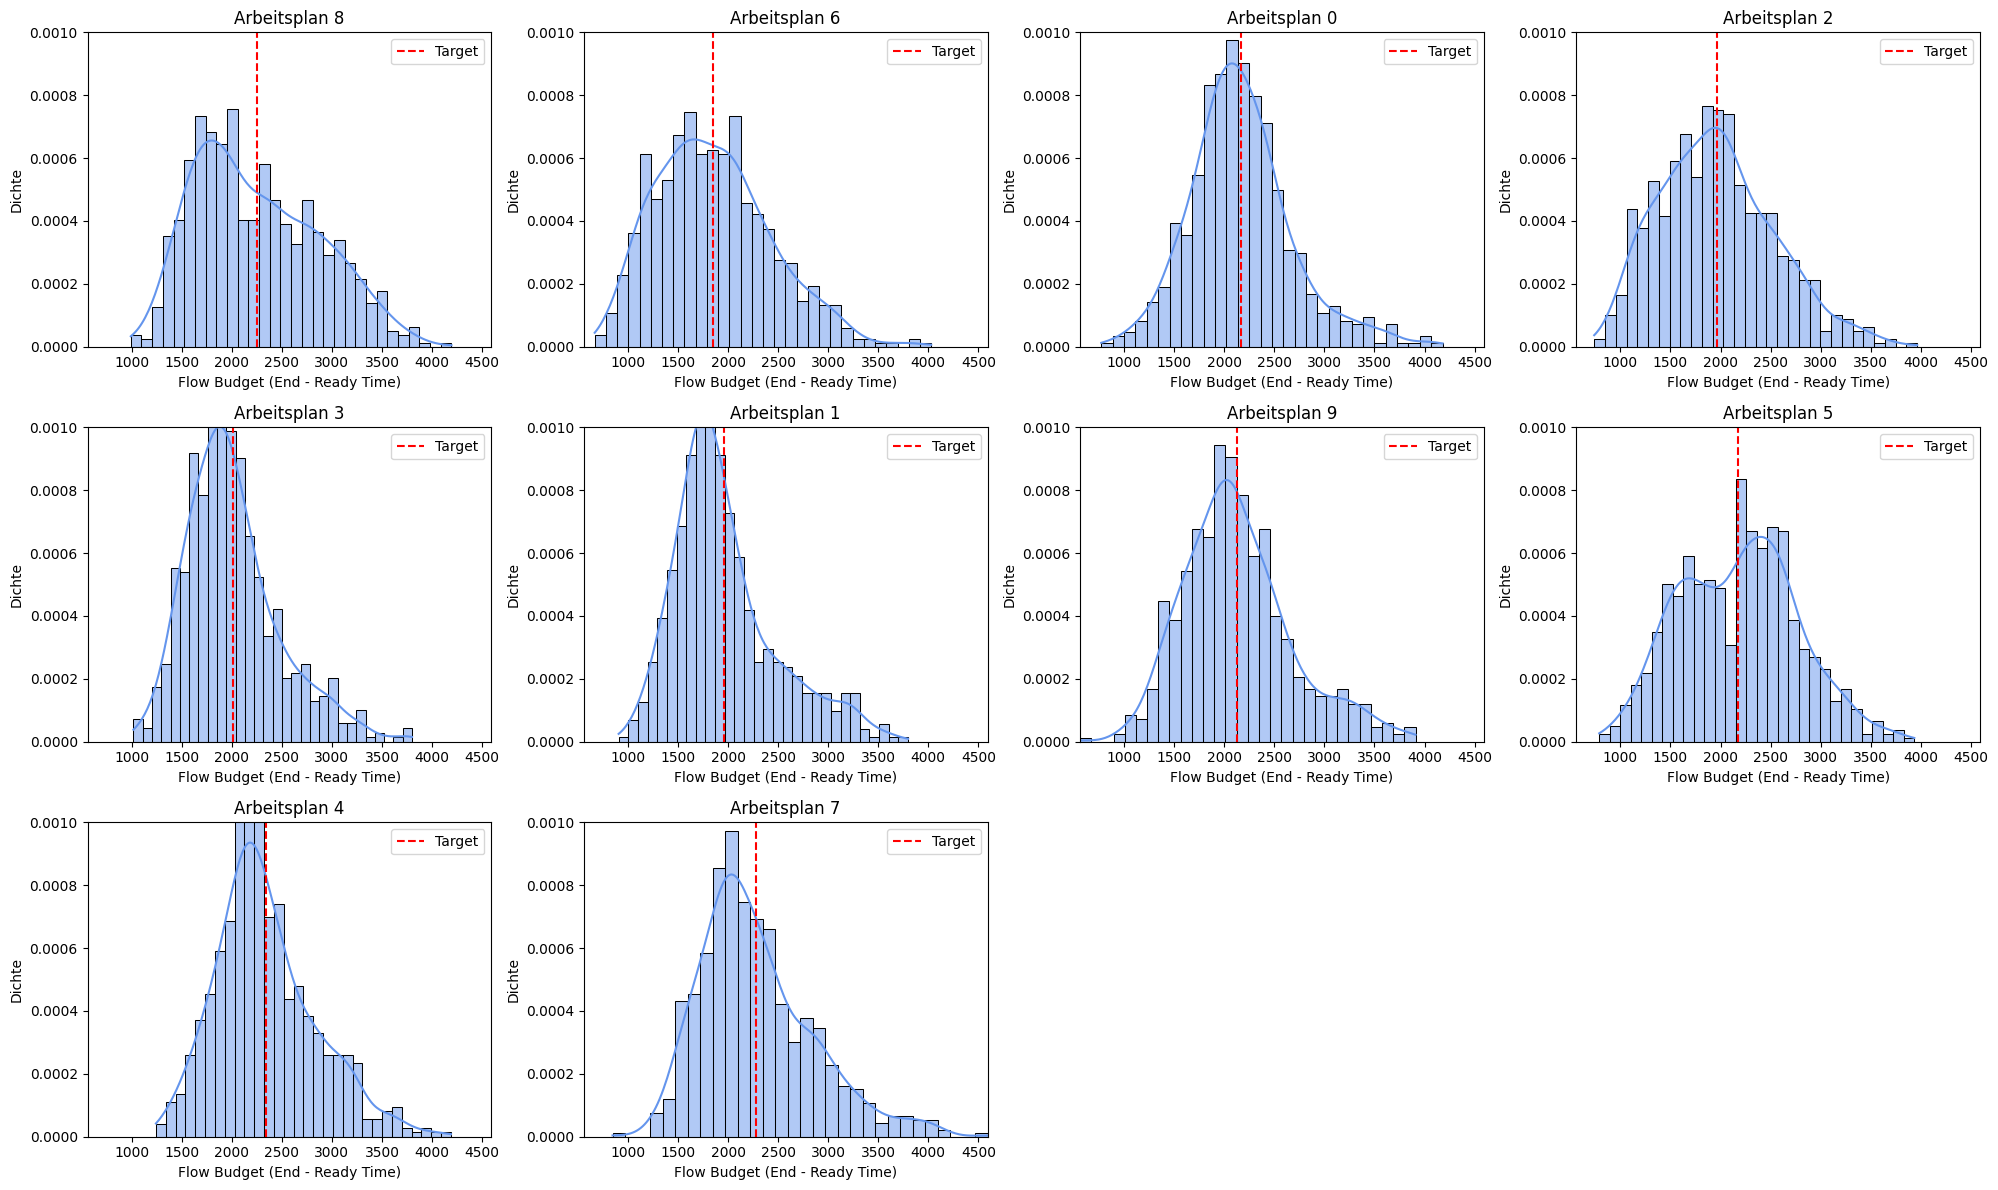

In [12]:
plotfig_empirical_flow_budget_distributions(df_jobs_times_temp, deadline_column="End")
plt.show()

### II. Generation of deadlines using log-normal distribution

In [12]:
df_jobs_times = add_groupwise_lognormal_deadlines_by_group_mean(df_jobs_times_temp, sigma=0.3)
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,End,Job Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660.0
1,J25-0001,6,129,1440,2336.0,416,2338.0
2,J25-0002,0,198,1440,2925.0,395,3744.0
3,J25-0003,2,243,1440,2801.0,568,3379.0
4,J25-0004,3,287,1440,2697.0,655,4856.0
5,J25-0005,1,498,1440,2630.0,510,3106.0
...,...,...,...,...,...,...,...
7244,J25-7244,3,518085,518400,520251.0,655,520389.0
7245,J25-7245,9,518089,518400,520296.0,540,519640.0
7246,J25-7246,6,518116,518400,520027.0,416,520157.0


### b) Plot of the new deadlines

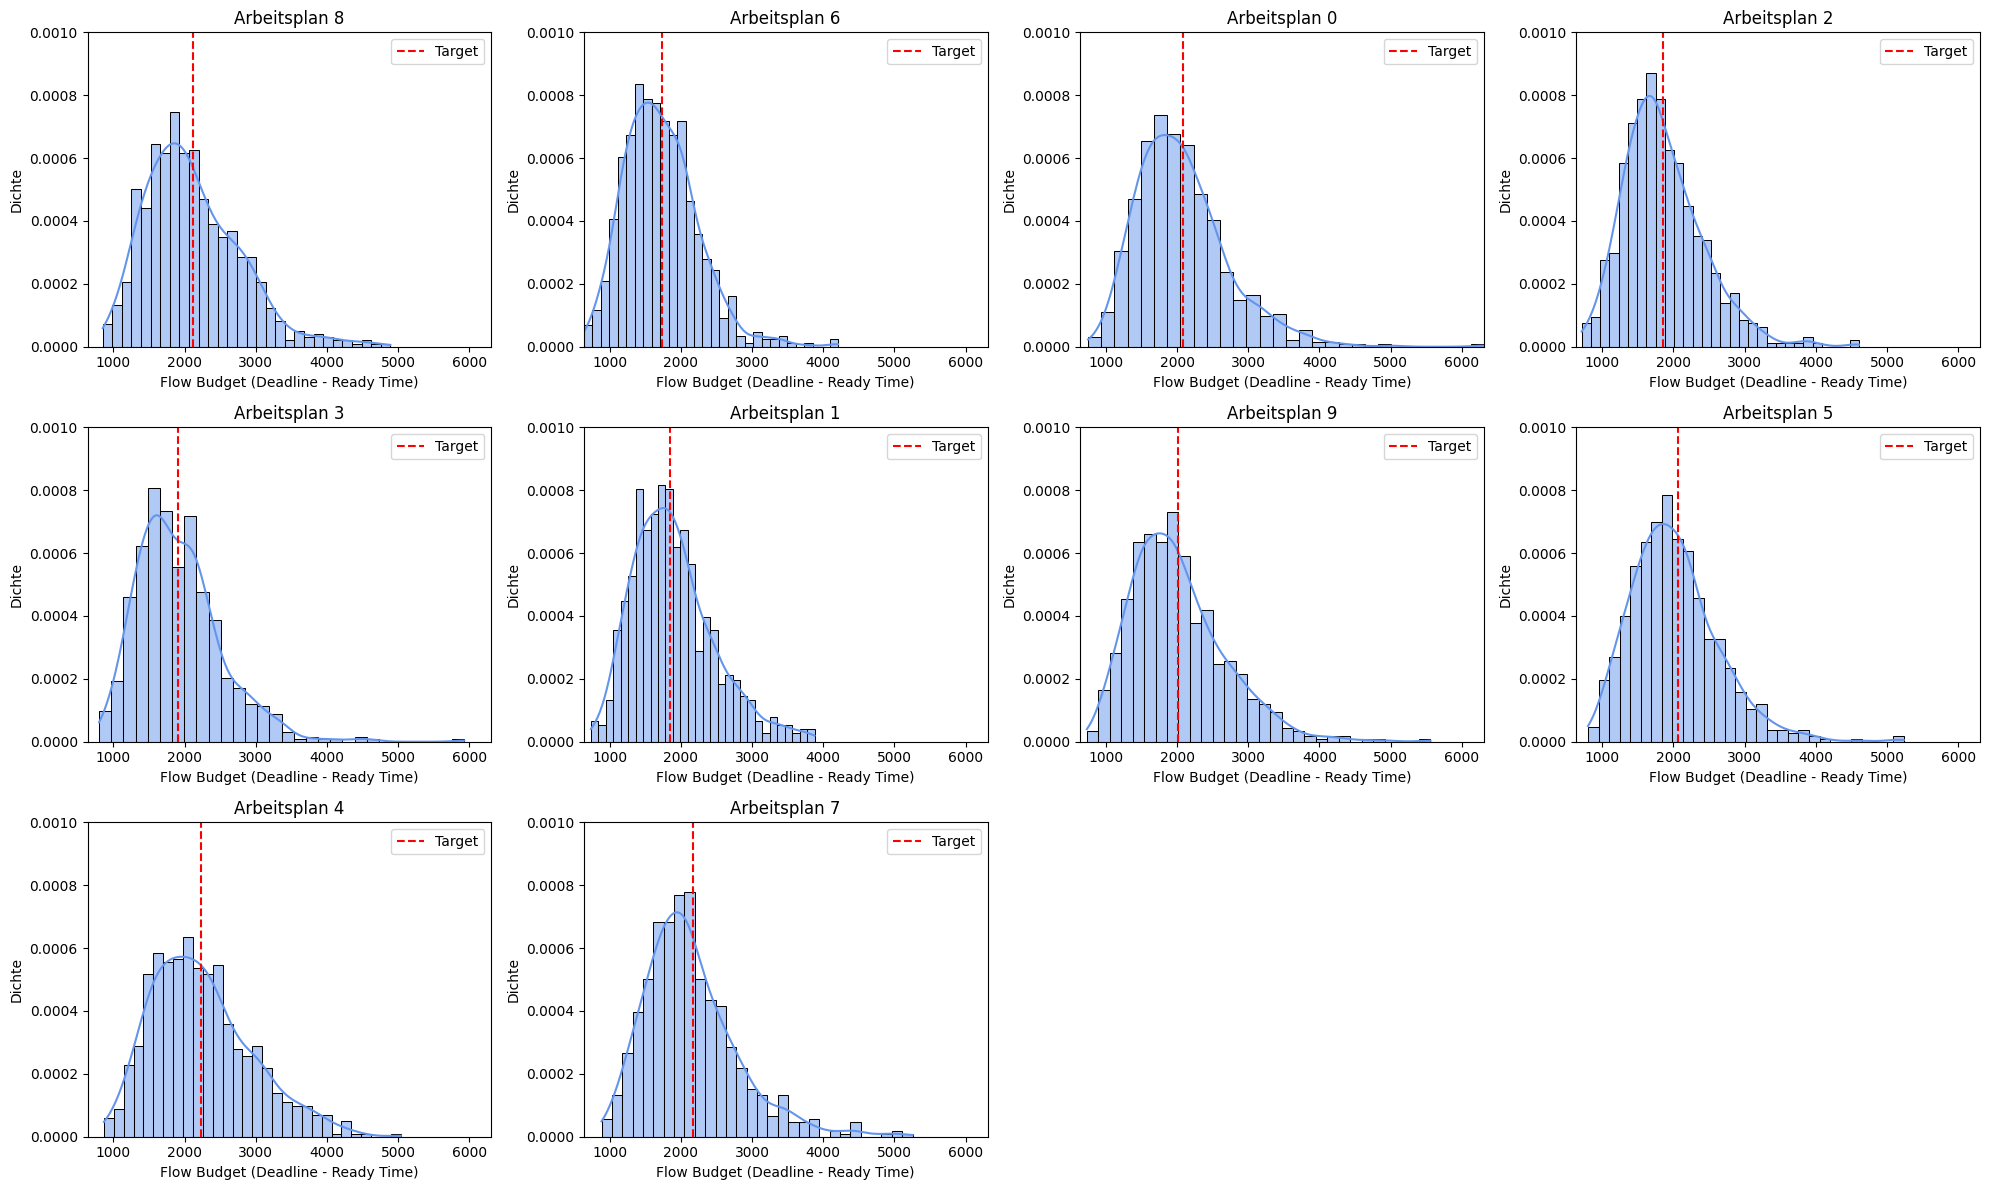

In [13]:
plotfig_empirical_flow_budget_distributions(df_jobs_times)
plt.show()

### c) Ensuring that the processing time is achievable to a certain extent in the best-case scenario

In [15]:
# min. 100 % of processing time for each job is covered in best-case
df_jobs_times_final = ensure_reasonable_deadlines(df_jobs_times, min_coverage = 1.0)

diff_count = (df_jobs_times_final["Deadline"] != df_jobs_times["Deadline"]).sum()

# Info: Compare the "Deadline" column
print(f"Number of different entries in 'Deadline': {diff_count}")

df_jobs_times_final

Number of different entries in 'Deadline': 0


,Job,Routing_ID,Arrival,Ready Time,Job Processing Time,Deadline
0,J25-0000,8,79,1440,597,3660
1,J25-0001,6,129,1440,416,2338
2,J25-0002,0,198,1440,395,3744
3,J25-0003,2,243,1440,568,3379
4,J25-0004,3,287,1440,655,4856
5,J25-0005,1,498,1440,510,3106
...,...,...,...,...,...,...
7244,J25-7244,3,518085,518400,655,520389
7245,J25-7245,9,518089,518400,540,519640
7246,J25-7246,6,518116,518400,416,520157


## Export

In [16]:
df_jssp.to_csv(basic_data_path / f"jssp_final.csv", index = False)

df_jobs_times_final.to_csv(basic_data_path / f"jobs_times_final.csv", index = False)
